In [25]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import pymongo
import os
import sys
import re
import time
import yaml

import botorch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.kernels import ScaleKernel, RBFKernel
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood

In [26]:
# Select experimental setup for which we are training a model
setup = "ip2"

In [27]:
# Open credential file for database
with open(os.path.join(os.getenv('HOME'), 'db.profile')) as f:
    db_profile = f.read()

# Connect to the MongoDB database with read-only access
db = pymongo.MongoClient(
    host="mongodb05.nersc.gov",
    username="bella_sf_ro",
    password=re.findall('SF_DB_READONLY_PASSWORD=(.+)', db_profile)[0],
    authSource="bella_sf")["bella_sf"]

# Extract data from the database as pandas dataframe
collection = db[setup]
df = pd.DataFrame( list(collection.find()) )

In [28]:
# Extract the name of inputs and outputs for this setup
with open("../../dashboard/config/variables.yml") as f:
    yaml_dict = yaml.safe_load( f.read() )
input_variables = yaml_dict[setup]["input_variables"]
input_names = [ v['name'] for v in input_variables.values() ] 
output_variables = yaml_dict[setup]["output_variables"]
output_names = [ v['name'] for v in output_variables.values() ]

Text(0.5, 0.5, 'z_target_um')

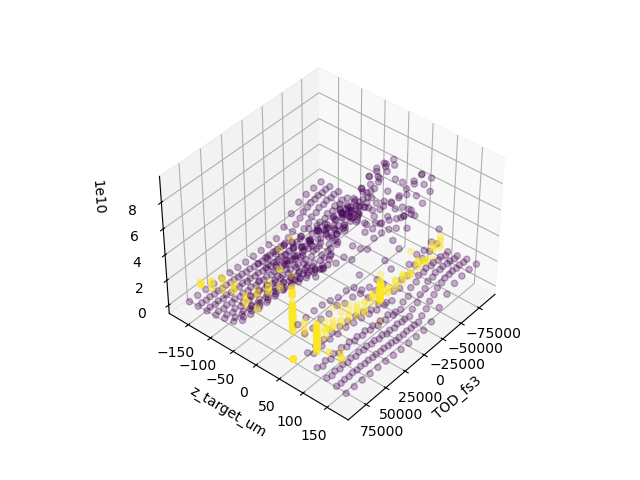

In [29]:
# Visualize the dimensional data
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( 
    df[input_names[0]], 
    df[input_names[-1]], 
    df[output_names[0]], 
    c=df.experiment_flag, 
    alpha=0.3)

ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel(input_names[0])
plt.ylabel(input_names[-1])

# Define a multi-input multi-task GP model

In [33]:
%%time
model = MultiTaskGP(
    torch.tensor( df[['experiment_flag']+input_names].values ),
    torch.tensor( df[output_names].values ),
    task_feature=0,
    covar_module=ScaleKernel(RBFKernel()),
    input_transform=Normalize(d=4),
    outcome_transform=Standardize(m=len(output_names))
)
# Fit the model
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

cov = model.task_covar_module._eval_covar_matrix()
print( 'Correlation: ', cov[1,0]/torch.sqrt(cov[0,0]*cov[1,1]).item() )

Correlation:  tensor(0.2891, dtype=torch.float64, grad_fn=<DivBackward0>)
CPU times: user 5.43 s, sys: 64.2 ms, total: 5.5 s
Wall time: 2.76 s


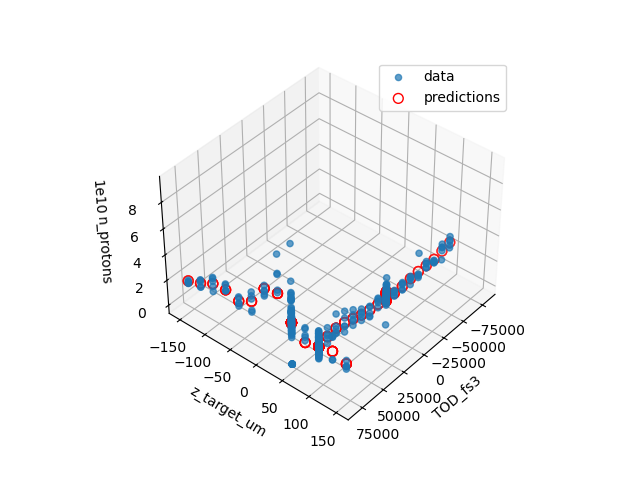

In [34]:
exp_flag = 1 # 0: show predictions on simulations ; 1: show preditions on experiments

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for simulation training set as 3D plot
ax.scatter( 
    df[df.experiment_flag==exp_flag][input_names[0]], 
    df[df.experiment_flag==exp_flag][input_names[-1]], 
    df[df.experiment_flag==exp_flag][output_names[0]],  
    alpha=0.7, label='data')

predictions = model.posterior(
    torch.tensor( df[df.experiment_flag==exp_flag][input_names].values, dtype=torch.float)
)

ax.scatter( 
    df[df.experiment_flag==exp_flag][input_names[0]], 
    df[df.experiment_flag==exp_flag][input_names[-1]],
    predictions.mean.detach()[:,exp_flag], 
    label='predictions', s=50, facecolors='none', edgecolors='r')

ax.view_init(elev=40., azim=40)
# Set labels and title
ax.set_xlabel(input_names[0])
ax.set_ylabel(input_names[-1])
ax.set_zlabel(output_names[0])

# Add legend
ax.legend()
# Show plot
plt.show()

# Saving an entire MultiTaskGP model in native PyTorch format


In [42]:
model_saved = torch.save(model, './saved_MultiTaskGP_model')

# Load pre-saved MultiTaskGP model

In [43]:
model_loaded = torch.load('./saved_MultiTaskGP_model', weights_only=False)
model_loaded.eval()

MultiTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (task_covar_module): IndexKernel(
    (raw_var_constraint): Positive()
  )
  (input_transform): Normalize()
  (outcome_transform): Standardize()
)

# Get prediction with pre-loaded MultiTaskGP model

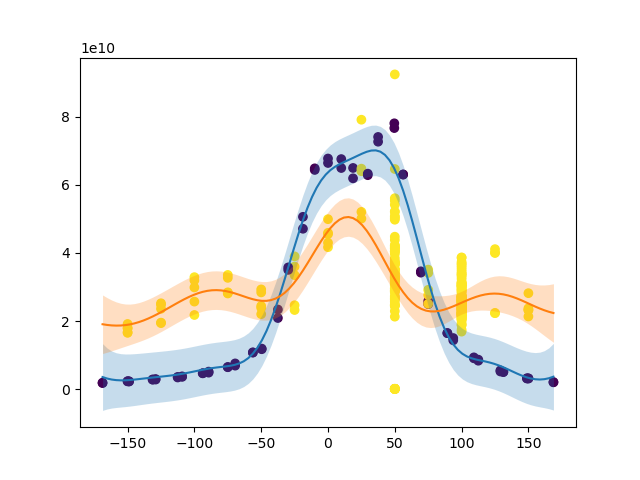

In [44]:
fig, ax = plt.subplots()

# Plot data for fixed TOD and GVD
gvd_fix = (df['GVD'].max() + df['GVD'].min()) / 2.
tod_max = df['TOD_fs3'].max()
select = df['TOD_fs3'] > 0.8*tod_max
ax.scatter(
    df[input_names[-1]][select], 
    df[output_names[0]][select], 
    c=df['experiment_flag'][select]
)

# Plot predictions
zmin, zmax = df['z_target_um'].min(), df['z_target_um'].max()

z_test_array = torch.tensor (np.linspace(zmin,zmax,100).reshape(-1, 1), dtype=torch.float32) 
TOD_test_array  = torch.tensor (np.linspace(tod_max,tod_max,100).reshape(-1, 1), dtype=torch.float32) 
GVD_test_array  = torch.tensor (np.linspace(gvd_fix,gvd_fix,100).reshape(-1, 1), dtype=torch.float32) 

predictions = model_loaded.posterior( torch.cat([ TOD_test_array, GVD_test_array, z_test_array], dim=1) )
with torch.no_grad():
    m = predictions.mean
    
    l,u = predictions.mvn.confidence_region()

exp_flag = 0
plt.plot( z_test_array.numpy(), m[:,exp_flag].numpy(), color='C0' )
plt.fill_between( z_test_array.numpy().flatten(), l[:,exp_flag], u[:,exp_flag], alpha = 0.25, lw = 0, color='C0')

exp_flag = 1
plt.plot( z_test_array.numpy(), m[:,exp_flag].numpy(), color='C1' )
plt.fill_between( z_test_array.numpy().flatten(), l[:,exp_flag], u[:,exp_flag], alpha = 0.25, lw = 0, color='C1')